
Training model for: Omerli_Fill


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MAE: 0.0223 | RMSE: 0.0292


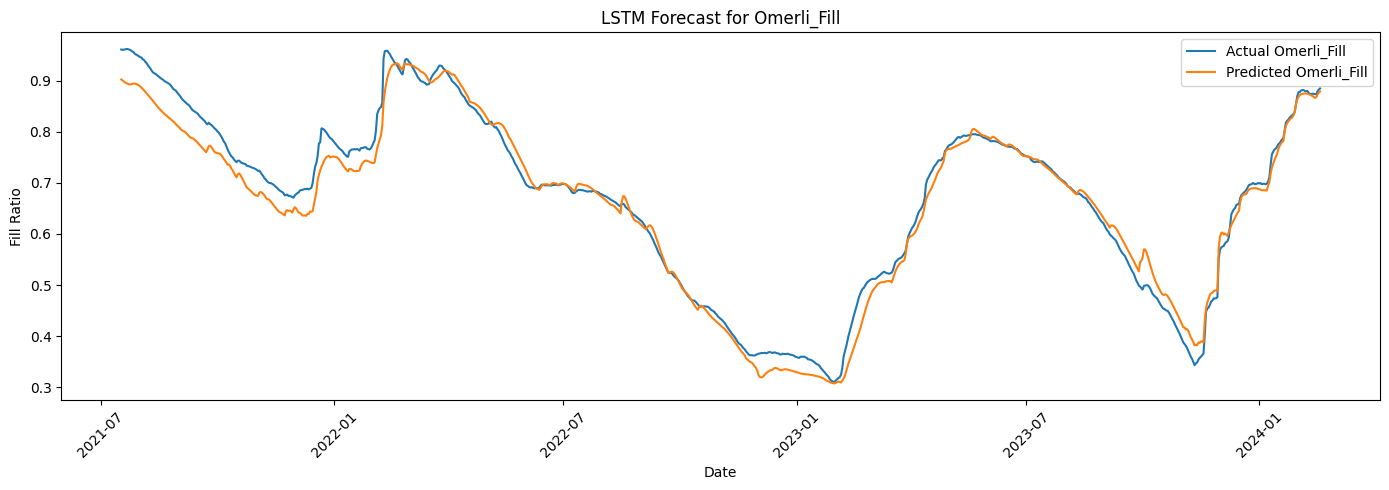


Training model for: Terkos_Fill


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
MAE: 0.011 | RMSE: 0.0139


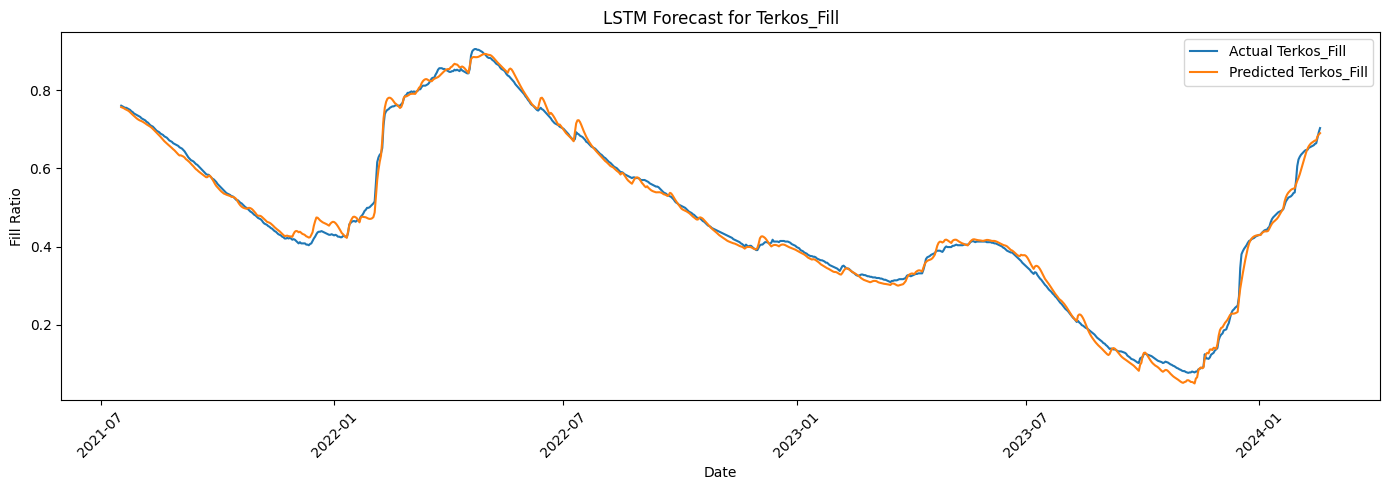


Training model for: Alibey_Fill


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
MAE: 0.0115 | RMSE: 0.0172


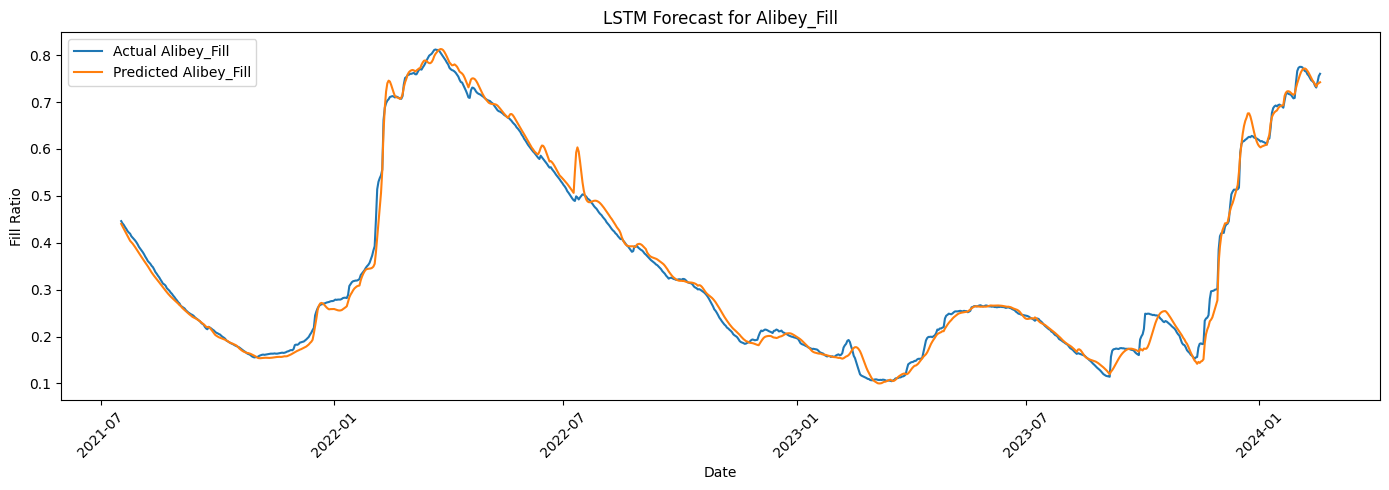


Training model for: Kazandere_Fill


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
MAE: 0.0253 | RMSE: 0.0379


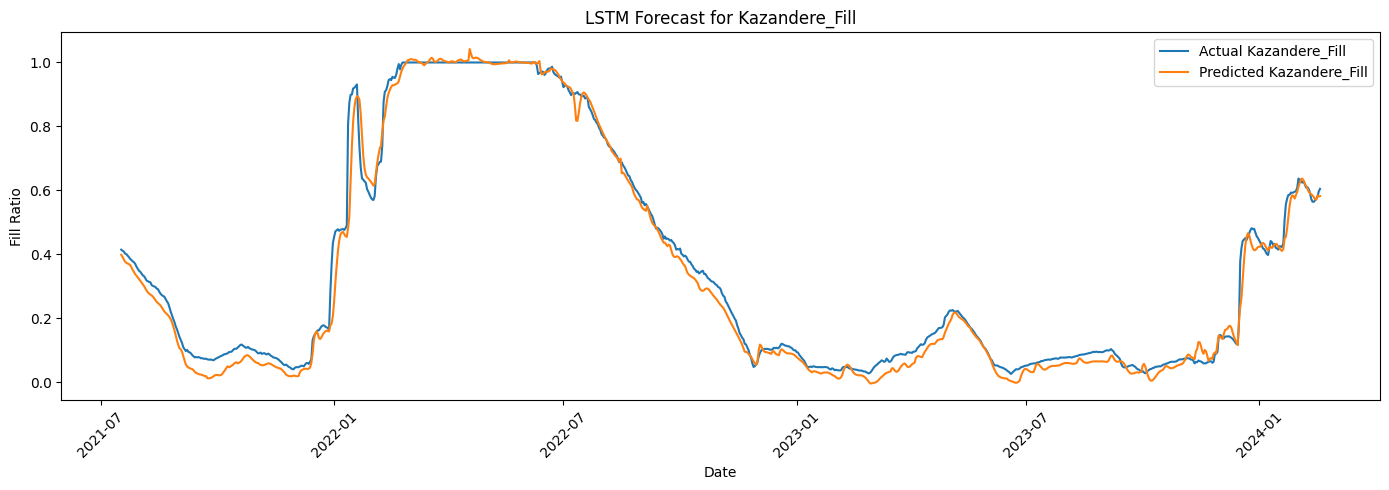


Training model for: Pabucdere_Fill


C:\Users\merta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
MAE: 0.0241 | RMSE: 0.0343


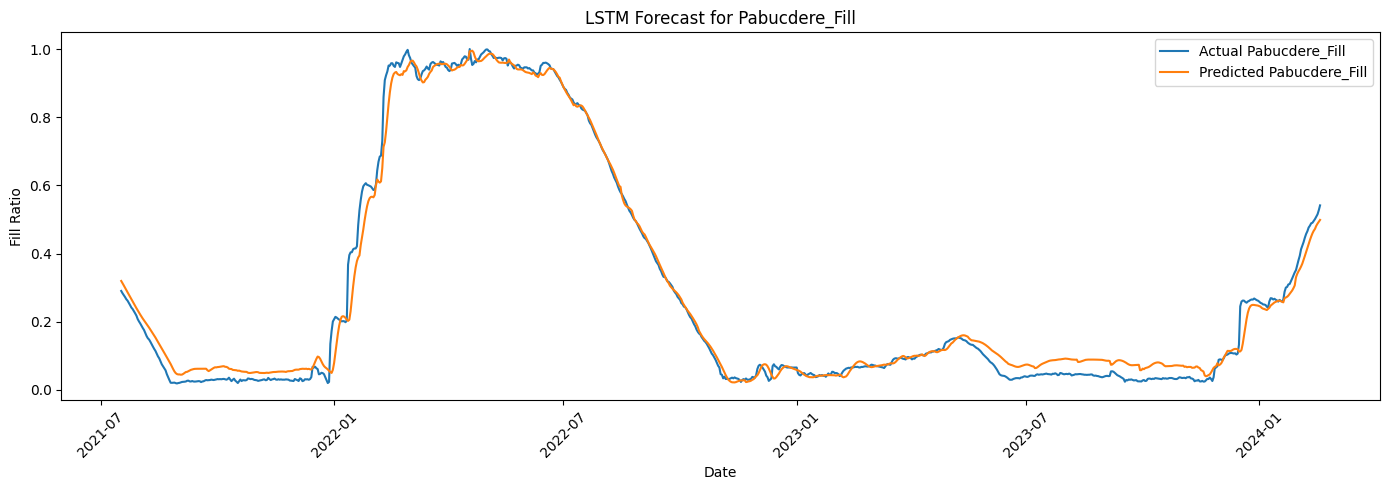

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Loading the dataset
df = pd.read_csv("../data/processed/merged_multivariate_dataset_cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])

# List of baraj fill ratio columns (target columns to forecast)
baraj_targets = [col for col in df.columns if col.endswith('_Fill')]

# Creating lag and rolling mean features for each target
for target in baraj_targets:
    df[f"{target}_lag1"] = df[target].shift(1)
    df[f"{target}_rolling7"] = df[target].rolling(window=7).mean()

# Dropping rows with NaNs after feature engineering
df = df.dropna().reset_index(drop=True)

# Saving original dates for later slicing
dates = df['Date'].reset_index(drop=True)

# Looping through each baraj to train a model and plot results
for target_column in baraj_targets:
    print(f"\nTraining model for: {target_column}")

    # Selecting features (excluding Date and current target)
    feature_columns = df.columns.difference(['Date'] + baraj_targets).tolist()
    X = df[feature_columns]
    y = df[[target_column]]

    # Scaling the features
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # Creating sequences for LSTM input
    def create_sequences(X, y, time_steps=60):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            Xs.append(X[i:(i + time_steps)])
            ys.append(y[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 60
    X_seq, y_seq = create_sequences(X_scaled, y_scaled)
    date_seq = dates[time_steps:]  # Aligning dates with y_seq

    # Splitting the data
    train_size = int(len(X_seq) * 0.7)
    val_size = int(len(X_seq) * 0.1)
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
    X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]
    date_test = date_seq[train_size + val_size:]

    # Building the LSTM model
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Making predictions
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # Calculating metrics
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    print(f"MAE: {round(mae, 4)} | RMSE: {round(rmse, 4)}")

    # Plotting with dates on x-axis
    plt.figure(figsize=(14, 5))
    plt.plot(date_test, y_test_inv, label=f"Actual {target_column}")
    plt.plot(date_test, y_pred_inv, label=f"Predicted {target_column}")
    plt.title(f"LSTM Forecast for {target_column}")
    plt.xlabel("Date")
    plt.ylabel("Fill Ratio")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


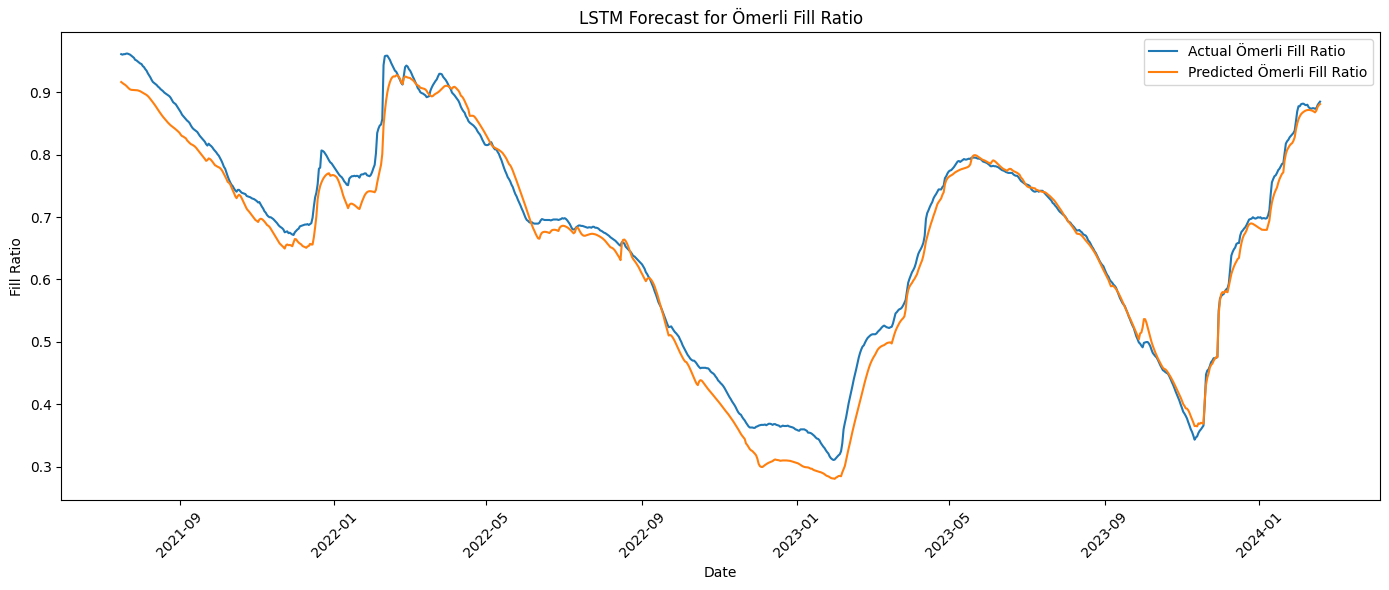

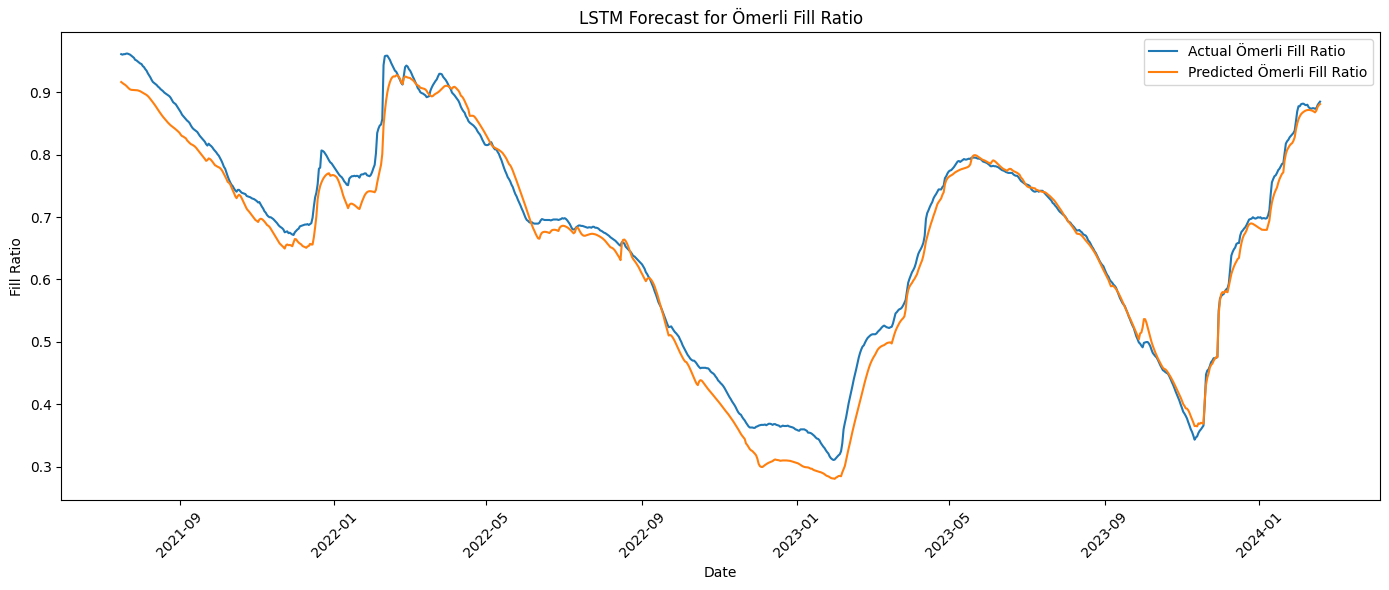

In [ ]:
# Getting the list of all dates after dropping NA
dates = df['Date'].reset_index(drop=True)

# Calculating how many dates were lost due to sequence length and dropped rows
time_steps = 60
total_sequences = len(dates) - time_steps

# Getting test start index (after splitting: 70% train, 10% val)
test_start_index = int(total_sequences * 0.8) + time_steps  # +time_steps accounts for initial sequence loss

# Extracting corresponding dates for the test set
test_dates = dates[test_start_index:test_start_index + len(y_test_inv)]

# Plotting the prediction vs actual with dates on x-axis
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_inv, label="Actual Ömerli Fill Ratio")
plt.plot(test_dates, y_pred_inv, label="Predicted Ömerli Fill Ratio")
plt.title("LSTM Forecast for Ömerli Fill Ratio")
plt.xlabel("Date")
plt.ylabel("Fill Ratio")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
